# Testing MFCC feature extraction

This requires vowel_discri to be on the python path.

In [1]:
%matplotlib inline

## Visualisation

In [ ]:
import soundfile
import vowel_discri.mfcc as mfcc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data, fs = soundfile.read('./bras.wav')
assert fs == 16000

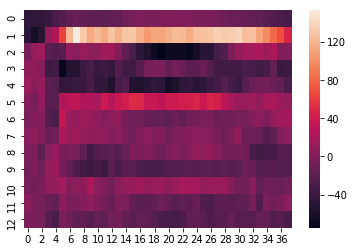

In [5]:
coefs = mfcc.mfcc(data, zeroth_coef='energy')
sns.heatmap(coefs[:, :])

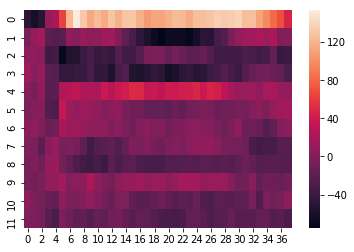

In [18]:
coefs = mfcc.mfcc(data, zeroth_coef='remove')
sns.heatmap(coefs[:, :])

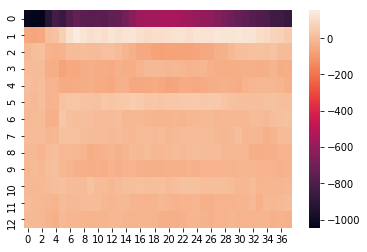

In [7]:
coefs = mfcc.mfcc(data)
sns.heatmap(coefs[:, :])

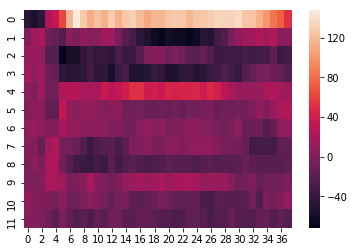

In [29]:
coefs = mfcc.mfcc(data, zeroth_coef='remove', cep_mean_norm=True)
sns.heatmap(coefs[:, :])

## Test ABX discriminability on WSJ corpus

This requires some of the material from the "Early phonetic learning without phonetic categories" paper.


### First extract MFCC and store them in h5features format to allow testing ABX phone discriminability.

In [55]:
import numpy as np
import os.path as path
import h5features

In [65]:
def read_wav(wavefile, onset=None, offset=None):
    data, fs = soundfile.read(wavefile)
    if onset is None:
        onset = 0
    if offset is None:
        offset = len(data)/float(fs)
    times = 1/(2*float(fs)) + np.arange(len(data))/float(fs)
    data = data[(times>=onset) & (times<=offset)]
    return data, fs


def extract_mfcc(wav_folder, segments_file, out_file, **kwargs):
    segments = {}
    with open(segments_file, 'r') as fh:
        for line in fh:
            seg, wav, onset, offset = line.strip().split()
            onset, offset = float(onset), float(offset)
            segments[seg] = wav, onset, offset
    utts, feats, times = [], [], []
    for i, seg in enumerate(segments):
        if i % 100 == 0:
            print("Done {} / {}".format(i, len(segments)))
        wav, onset, offset = segments[seg]
        wavefile = path.join(wav_folder, wav)
        data, fs = read_wav(wavefile, onset=onset, offset=offset)
        assert fs == 16000
        coefs = mfcc.mfcc(data, **kwargs)
        feats.append(coefs.T)
        utts.append(seg)
        times.append(0.0125 + np.arange(coefs.shape[1])*0.01)
    data = h5features.Data(utts, times, feats, check=True)
    with h5features.Writer(out_file) as fh:
        fh.write(data, '/features')

In [57]:
# quick test of wav_read
data, fs = read_wav('/Users/admin/Documents/PhD/Data/GPJ_match_WSJ_test/wavs/00b.wav', 11, 28)
soundfile.write('/Users/admin/Documents/PhD/Data/GPJ_match_WSJ_test/test.wav', data, samplerate=fs)

In [66]:
conditions = [('energy', True),  ('energy', False),
              ('remove', False), ('remove', True),
              (None, False), (None, True)]
root = '/Users/admin/Documents/PhD/Data/GPJ_match_WSJ_test/'
for zeroth, norm in conditions[1:]:
    print(zeroth)
    print(norm)
    data = extract_mfcc(root + 'wavs/',
                        root + 'segments.txt',
                        root + 'mfcc/mfcc_{}_{}.features'.format(zeroth, norm),
                        zeroth_coef=zeroth, cep_mean_norm=norm)

energy
False
Done 0 / 4871
Done 100 / 4871
Done 200 / 4871
Done 300 / 4871
Done 400 / 4871
Done 500 / 4871
Done 600 / 4871
Done 700 / 4871
Done 800 / 4871
Done 900 / 4871
Done 1000 / 4871
Done 1100 / 4871
Done 1200 / 4871
Done 1300 / 4871
Done 1400 / 4871
Done 1500 / 4871
Done 1600 / 4871
Done 1700 / 4871
Done 1800 / 4871
Done 1900 / 4871
Done 2000 / 4871
Done 2100 / 4871
Done 2200 / 4871
Done 2300 / 4871
Done 2400 / 4871
Done 2500 / 4871
Done 2600 / 4871
Done 2700 / 4871
Done 2800 / 4871
Done 2900 / 4871
Done 3000 / 4871
Done 3100 / 4871
Done 3200 / 4871
Done 3300 / 4871
Done 3400 / 4871
Done 3500 / 4871
Done 3600 / 4871
Done 3700 / 4871
Done 3800 / 4871
Done 3900 / 4871
Done 4000 / 4871
Done 4100 / 4871
Done 4200 / 4871
Done 4300 / 4871
Done 4400 / 4871
Done 4500 / 4871
Done 4600 / 4871
Done 4700 / 4871
Done 4800 / 4871
remove
False
Done 0 / 4871
Done 100 / 4871
Done 200 / 4871
Done 300 / 4871
Done 400 / 4871
Done 500 / 4871
Done 600 / 4871
Done 700 / 4871
Done 800 / 4871
Done 900 / 

### Second run the WSJ discrimination task on this features (done on a remote cluster)

### Third look at results

In [2]:
from scone_phobia import apply_analysis
from scone_phobia.analyses.avg_error import avg_error
import scone_phobia.metadata.add_metadata as add_metadata
import seaborn as sns

In [3]:
# Loading (or computing if it's the first time) avg_error analysis results with full resamples

mp_folder = '/Users/admin/Documents/PhD/Data/vowel_discri/mp_scores'

analysis = avg_error
df_avg = apply_analysis(analysis, mp_folder,
                        add_metadata=add_metadata.language_register,
                        resampling=False)

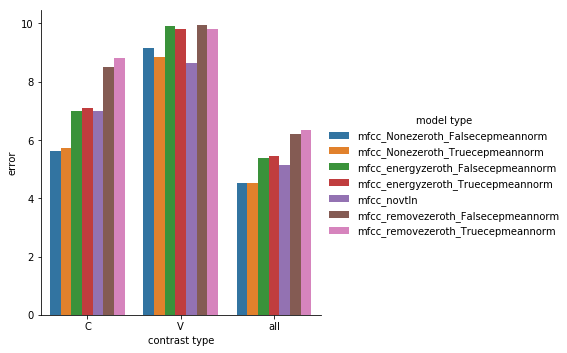

In [4]:
sns.catplot(data=df_avg, kind='bar', y='error', hue='model type', x='contrast type')

Conclusion: for within-speaker phone discrimination:
    - cepstral mean normalization does not have much effect overall (tends to make consonant a bit harder to discriminate and vowel a bit easier) -> do not do it
    - log-energy: big effect unscaled zeroth-order MFCC appears best????
        - Does this have to do with DTW aligning signal based on energy profile due to scale unbalance???
            -> how come there is this unbalance in the first place, isn't this supposed to be a PCA?
                -> maybe log-energy synchronization (DTW or otherwise) + cosine distance on aligned signals without the energy would work very well? (or more generally on signal deconvoluted from pitch+prosody contours)
   
    - Short-term: take normalized DTW with basic MFCC (no log energy or removing of first coefficient) and no cepstral mean normalization. 